<a href="https://colab.research.google.com/github/Baze-Bai/XAI/blob/HW2/Asign2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment 3
### Description
### Zejun(Baze) Bai

# Install required packages

In [3]:
! pip install pytorch-tabnet lime numpy pandas scikit-learn matplotlib alibi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 70.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 30.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 828.5 kB/s eta 0:00:00
   

# Import the related packages

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error
from pytorch_tabnet.tab_model import TabNetRegressor  # Use TabNetRegressor as the pre-trained model
from lime.lime_tabular import LimeTabularExplainer
from alibi.explainers import AnchorTabular            # Use Anchors to explain the model
from sklearn.datasets import fetch_openml
import seaborn as sns



# References
## Dataset:
Harrison, D., & Rubinfeld, D. L. (1978). "Hedonic housing prices and the demand for clean air".
Journal of Environmental Economics and Management, 5(1), 81-102.

## Pre-trained model:
Arik, S. O., & Pfister, T. (2021). "TabNet: Attentive Interpretable Tabular Learning".
Proceedings of the AAAI Conference on Artificial Intelligence, 35(8), 6679-6687.

## AI:
ChatGpt 4o is used to assist with the code.



# Why choose Anchors?
# Strengths
Anchors is more explainable than others, since it generates rules, which are more clear and easier to explain than the linear weights in LIME and SHAP. The rules are more intuitive for human. Compared with LIME and SHAP, its requirement for computational resource is the least. It is stable with clear rules. It can explain mutiple kinds of features, like text, image and table data.

# Limitation
Anchors can not fit in the complicated cases. For some complex models like GPT-2, it can not explain the process of predicting. And if there are very complex paterns between features or the dimension is very high, it is hard to use Anchors to genarate uesful rules.

# potential improvements
1): When the model is complex and the dimension of features is high, we can combine Anchors with LIME.

2): Use visualization to make the explaination more clear.


# Load Boston Housing Dataset

In [19]:
# Download data
boston = fetch_openml(name="boston", version=1, as_frame=True)
df = boston.frame

# Target labels
y = df["MEDV"]

# Discrete variable
categorical_features = ["CHAS", "RAD"]

# Consistent variable
continuous_features = [col for col in df.columns if col not in ["MEDV"] + categorical_features]

# Spilt the train/test data
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["MEDV"]), y, test_size=0.2, random_state=42)

# Standalize the consistent variables
scaler = StandardScaler()
X_train_continuous = scaler.fit_transform(X_train[continuous_features])
X_test_continuous = scaler.transform(X_test[continuous_features])

X_train_categorical = np.hstack([
    X_train["CHAS"].values.reshape(-1, 1),
    X_train["RAD"].values.reshape(-1, 1)
])

X_test_categorical = np.hstack([
    X_test["CHAS"].values.reshape(-1, 1),
    X_test["RAD"].values.reshape(-1, 1)
])

X_train_scaled = np.hstack([X_train_continuous, X_train_categorical])
X_test_scaled = np.hstack([X_test_continuous, X_test_categorical])



# Fine tuning pre-trained model

In [20]:

X_train_scaled = np.array(X_train_scaled, dtype=np.float32)
X_test_scaled = np.array(X_test_scaled, dtype=np.float32)

y_train_np = np.array(y_train, dtype=np.float32).reshape(-1, 1)
y_test_np = np.array(y_test, dtype=np.float32).reshape(-1, 1)

# Initialize the TabNet
tabnet = TabNetRegressor()

# Fine tuning
tabnet.fit(
    X_train_scaled, y_train_np,
    eval_set=[(X_test_scaled, y_test_np)],
    max_epochs=200, patience=20, batch_size=256, virtual_batch_size=128,
    num_workers=0
)

# Prediction
y_pred = tabnet.predict(X_test_scaled)

# Evaluate the model, calculate MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Test dataset MSE: {mse:.4f}")


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 619.07166| val_0_mse: 617.41638|  0:00:00s
epoch 1  | loss: 619.49243| val_0_mse: 663.67578|  0:00:00s
epoch 2  | loss: 572.15186| val_0_mse: 569.26135|  0:00:00s
epoch 3  | loss: 566.96643| val_0_mse: 510.73346|  0:00:00s
epoch 4  | loss: 556.02472| val_0_mse: 495.19507|  0:00:00s
epoch 5  | loss: 528.08209| val_0_mse: 466.12482|  0:00:00s
epoch 6  | loss: 530.94891| val_0_mse: 449.69766|  0:00:00s
epoch 7  | loss: 509.10388| val_0_mse: 432.53351|  0:00:00s
epoch 8  | loss: 455.05356| val_0_mse: 420.21045|  0:00:00s
epoch 9  | loss: 451.08713| val_0_mse: 398.26199|  0:00:00s
epoch 10 | loss: 432.0199| val_0_mse: 377.74039|  0:00:00s
epoch 11 | loss: 412.07956| val_0_mse: 356.21118|  0:00:00s
epoch 12 | loss: 379.95993| val_0_mse: 334.43954|  0:00:00s
epoch 13 | loss: 362.75702| val_0_mse: 310.86417|  0:00:00s
epoch 14 | loss: 348.68958| val_0_mse: 290.68835|  0:00:00s
epoch 15 | loss: 343.09525| val_0_mse: 269.90604|  0:00:00s
epoch 16 | loss: 320.435 | val_0_mse: 250

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# Use Anchors to explain TabNet

In [37]:
feature_names = continuous_features + ["CHAS", "RAD"]

# Initialize Anchors explainer
explainer = AnchorTabular(
    predictor=lambda x: tabnet.predict(x).flatten(),
    feature_names=feature_names
)

# Fit the training data
explainer.fit(X_train_scaled, disc_perc=(10, 30, 50, 70, 90))

# Select a sample to explain
idx = 50
instance = X_test_scaled[idx].reshape(1, -1)

# Generate the explaination
explanation = explainer.explain(instance, threshold=0.01)

# Output the explaination
print("Anchors rules:")
print(explanation.anchor)
print("Precision:", explanation.precision)
print("Coverage:", explanation.coverage)



Anchors rules:
['4.00 < RAD <= 5.00', '0.33 < AGE <= 0.81', '-0.40 < CRIM <= -0.38', '-0.69 < TAX <= -0.45', '-0.22 < LSTAT <= 0.36', '-0.74 < INDUS <= -0.35', 'CHAS <= 0.00', '0.36 < DIS <= 1.52', '0.42 < B <= 0.44', '-1.63 < PTRATIO <= -0.41', '-0.50 < RM <= -0.15', '-0.72 < NOX <= -0.16', '-0.50 < ZN <= 1.45']
Precision: 0.0
Coverage: 0.0


# Visualization

<ipython-input-35-2662016a413e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=anchor_rules, x=[precision] * len(anchor_rules), palette="Blues_r")


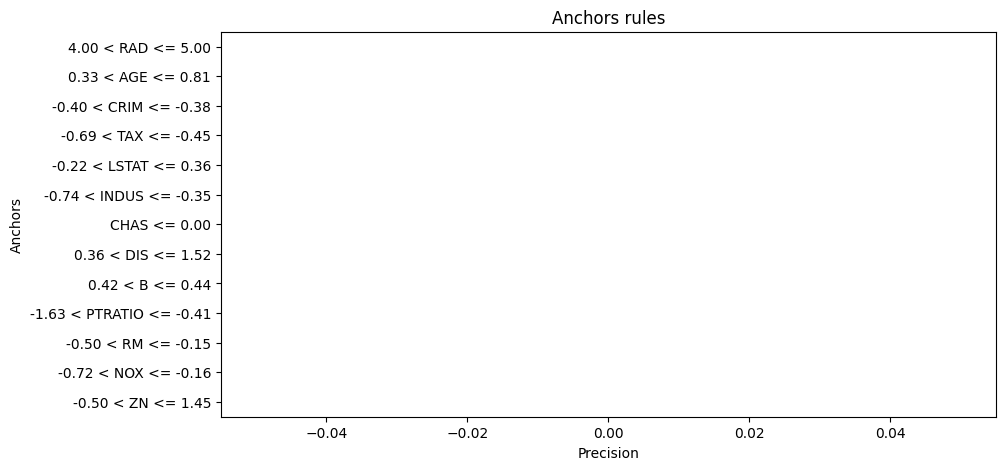

In [35]:
# Obtain the rules, precision and coverage
anchor_rules = explanation.anchor
precision = explanation.precision
coverage = explanation.coverage

plt.figure(figsize=(10, 5))
sns.barplot(y=anchor_rules, x=[precision] * len(anchor_rules), palette="Blues_r")
plt.xlabel("Precision")
plt.ylabel("Anchors")
plt.title("Anchors rules")
plt.show()

# Explaination
This bar plot visualizes Anchors explanation rules for a selected instance.

Y-axis (Anchors Rules): Conditions that influenced the model’s prediction (e.g., 4.00 < RAD <= 5.00, CHAS <= 0.00).

X-axis (Precision): How reliable each rule is in explaining the prediction.

Issue: Precision values are too small, making the plot appear almost empty. And the coverage is also small, which means Anchors doesn't fit this case.

Fix: Combine Anchors with LIME to capture higher paterns of features.